<a href="https://colab.research.google.com/github/valmeau/w07-final-project/blob/master/bvh_model_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/valmeau/w07-final-project/blob/master/bvh_exploratory_nb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# W207 - Forest Cover Type Prediction

## Final Project Baseline

## Team:
- Brittney Van Hese
- Prabhaker Narsina
- Valérie Méausoone


### Environment Set-Up

In [2]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm
from google.colab import files
from sklearn.svm import SVC

import io




%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

### **Exploratory Data Analysis**
We perform an EDA on the training dataset provided by the Kaggle competition.

#### Importing the Data

To begin, we import that training data set that is provided for us as a part of the problem. Then we display the columns found in our data set, along with a preview of the data contained within.

In [4]:
#uploading train data to colab - this command only needs to be run once. 
uploaded_train = files.upload()

train_df = pd.read_csv(io.BytesIO(uploaded_train['train.csv']), index_col='Id')
col_names = train_df.columns.tolist()

print("Column names:")
print(col_names)

print("\nSample data:")
train_df.head()

Saving train.csv to train (3).csv
Column names:
['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40', 'Cover_Type']

Sample data:


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
3,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
4,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
5,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


From the problem prompt, the objective is to predict the Cover Type, or tree coverage species, to be expected in an area given the descriptive features of the area like: Elevation, shade levels, and distance to nearby water and roads. Therefore, we will separate out the target class to be predicted and count the remaining features and the total number of observations they describe. 

In [5]:
# Isolate target data
cover_type = train_df['Cover_Type']
y = np.array(cover_type)

# Dropping output from feature space
to_drop = ['Cover_Type']
cover_feat_space = train_df.drop(to_drop, axis = 1)

# Pull out geatures for future use
features = cover_feat_space.columns
X = np.array(cover_feat_space).astype(np.float)

print("Feature space hold %d observations and %d features" % X.shape)
print("Unique target labels:", np.unique(y))

Feature space hold 15120 observations and 54 features
Unique target labels: [1 2 3 4 5 6 7]


#### Assessing Data Quality

Before attempting any predictions, it is important we check the training data that will be passed to any models. Here we check of any missing or erroneous values. 

In [6]:
# Assessing missingness
print("There are", np.count_nonzero(np.isnan(X)), "missing values among our features")
print("There are", np.count_nonzero(np.isnan(y)), "missing values among our target values")

#Assessing plausibility of values
print("\nLooking at summary statistics for our training data:")
train_df.describe()

There are 0 missing values among our features
There are 0 missing values among our target values

Looking at summary statistics for our training data:


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
count,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.0,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.0,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000
mean,2749.322553,156.676653,16.501587,227.195701,51.076521,1714.023214,212.704299,218.965608,135.091997,1511.147288,0.237897,0.033003,0.419907,0.309193,0.023479,0.041204,0.063624,0.055754,0.010913,0.042989,0.0,0.000066,0.000661,0.141667,0.026852,0.015013,0.031481,0.011177,0.0,0.007540,0.040476,0.003968,0.003042,0.009193,0.001058,0.022817,0.050066,0.016997,0.000066,0.003571,0.000992,0.000595,0.085384,0.047950,0.021958,0.045635,0.040741,0.001455,0.006746,0.000661,0.002249,0.048148,0.043452,0.030357,4.000000
std,417.678187,110.085801,8.453927,210.075296,61.239406,1325.066358,30.561287,22.801966,45.895189,1099.936493,0.425810,0.178649,0.493560,0.462176,0.151424,0.198768,0.244091,0.229454,0.103896,0.202840,0.0,0.008133,0.025710,0.348719,0.161656,0.121609,0.174621,0.105133,0.0,0.086506,0.197080,0.062871,0.055075,0.095442,0.032514,0.149326,0.218089,0.129265,0.008133,0.059657,0.031482,0.024391,0.279461,0.213667,0.146550,0.208699,0.197696,0.038118,0.081859,0.025710,0.047368,0.214086,0.203880,0.171574,2.000066
min,1863.000000,0.000000,0.000000,0.000000,-146.000000,0.000000,0.000000,99.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2376.000000,65.000000,10.000000,67.000000,5.000000,764.000000,196.000000,207.000000,106.000000,730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,2752.000000,126.000000,15.000000,180.000000,32.000000,1316.000000,220.000000,223.000000,138.000000,1256.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
75%,3104.00000

The variables all have plausible distributions. We notice a negative minimum for "Vertical_Distance_To_Hydrology" but understand that it is a plausible minimum value, as the surface of the nearest water source for areas - such as mountainous regions - will be beneath the area being evaluated. 

Therefore, we conclude there are no obvious issues with the data set and proceed with exploration of the features.



#### Feature Exploration

First, we ensure that each target class is represented fairly in the data set. 

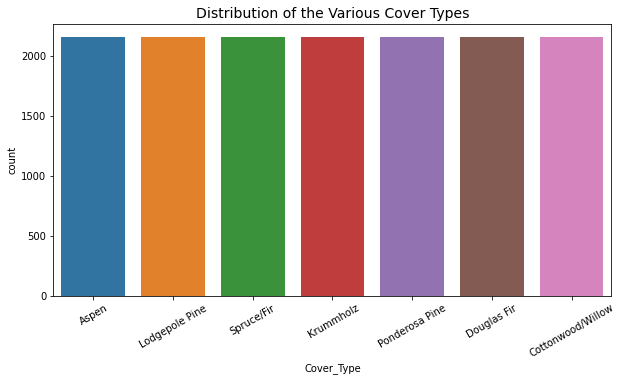

In [29]:
#Plotting the target
#Renaming the target labels to make them more meaningful
train_df['Cover_Type'].replace({1:'Spruce/Fir', 2: 'Lodgepole Pine', 3: 'Ponderosa Pine', 4: 'Cottonwood/Willow', 5: 'Aspen', 6: 'Douglas Fir', 7: ' Krummholz'}, inplace=True)

fig, ax = plt.subplots(figsize=(10,5))
ax.set_title("Distribution of the Various Cover Types", size = 14)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
ax = sns.countplot(x = "Cover_Type", data = train_df)

From the figure above, it is clear that each target class is equally represented in the data set. Next, we see if any of the features offer distinctions between our Cover Types; starting with our categorical features. 

In [28]:
#Plotting catgorical features
#Transform binary into a few categorical variables, and giving them more meaningful names where possible
train_df = train_df.rename(columns={"Wilderness_Area1":"Rawah_WA","Wilderness_Area2":"Neota_WA",
"Wilderness_Area3":"Comanche_Peak_WA","Wilderness_Area4":"Cache_la_Poudre_WA"})
train_df['Wilderness_Areas'] = (train_df.iloc[:,10:14] == 1).idxmax(1)

fig = px.histogram(train_df, x="Wilderness_Areas", color="Cover_Type", barmode="group", title='Distribution of Wildreness Area by Cover Type')
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.show()

In [9]:
train_df['Soil_Type'] = (train_df.iloc[:,15:55] == 1).idxmax(1)
fig = px.histogram(train_df, x="Soil_Type", color="Cover_Type", title='Distribution of the Soil Types by Cover Types')
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.show()

Each of our categorical feature values appear to provide separation between our target classes. Next let us look at the distributions of our numerical features.

From all the above plots, we do see some separation between features and classes, but we also see significant overlap of the numerical feature distributions. This could cause problems for our predictions depending on the model we select.

In [10]:
fig = px.histogram(train_df, x="Elevation", color="Cover_Type", title= "Distribution of Cover Types")
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.show()

### **Summary**

To conclude our baseline, we have established an initial 1-NN model with avg. Accuracy of 83.4%. We selected accuracy as the performance metric to be evaluated for a few reasons.   

First, it is a easily interpretable metric to allow us to quickly compare our initial models. Secondly, for many of these KNN models with varying K values, we see may equal Precision, Recall, and F1-score, leaving accuracy as the only distinguishing metric between the model variations. 

While we do not know the applied context of our problem to know what metric would be most appropriate to evaluate, we can make educated guesses. For example, if the application of our model is to evaluate fire risk based on the cover type of the area, i.e. the prediction of the cover type determines if the fire risk is 'safe' or 'not-safe'. In this case, we would be more concerned with optimizing model Precision, as our False Positives (predicting a 'safe' cover_type when it is a 'not-safe' cover_type) would carry a high risk. Similarly, we could imagine that Forest Cover Type prediction is useful in monitoring ecosystems. Indeed, having a machine learning model that accurately predicts an expected type of tree (i.e.: optimizing model Precision) could be critical to ensure comparison with the changing reality of cover type due to factors like climate change.   

As such, secondary to accuracy, precision will be relevant to monitor as we assess other machine learning models. In the absence of a clear application, F1-score, a generally used measured that balances precision and recall, will also be worth considering.   

### **PCA**

1 component(s) explain 72.17% of total variance
2 component(s) explain 94.76% of total variance
3 component(s) explain 98.35% of total variance
4 component(s) explain 99.46% of total variance
5 component(s) explain 99.87% of total variance
10 component(s) explain 100.00% of total variance
20 component(s) explain 100.00% of total variance


Text(0, 0.5, '% of Variance')

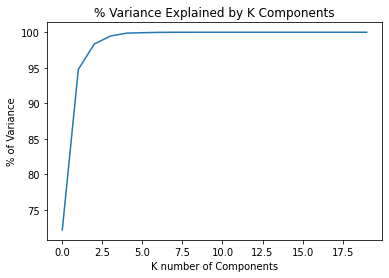

In [11]:
  K=20
  k = np.array([1,2,3,4,5,10,20])
  pca = PCA()
  pca.fit_transform(X)

  explained_var_percent = pca.explained_variance_ratio_[:K].cumsum()

  for i in k:
    print('{0} component(s) explain {1:5.2f}% of total variance'.format(i, 100*explained_var_percent[i-1]))
  
  plt.plot(100*explained_var_percent)
  plt.title('% Variance Explained by K Components')
  plt.xlabel('K number of Components')
  plt.ylabel('% of Variance')


Text(0.5, 0, 'Principal Component 1')

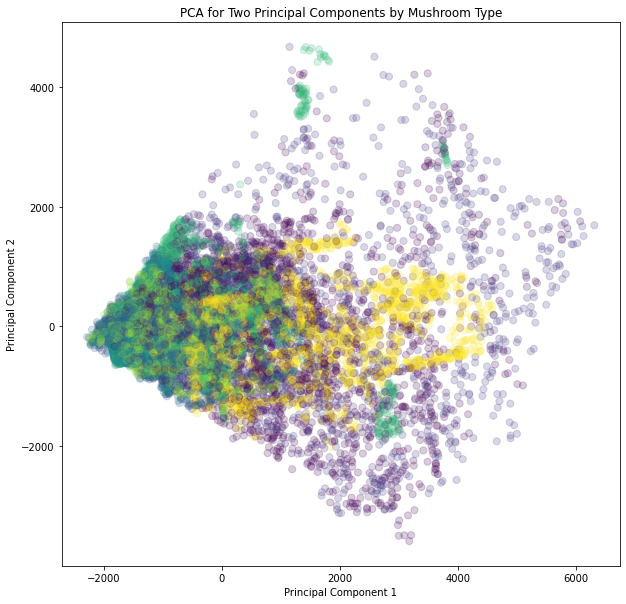

In [12]:
  two_pca = PCA(n_components=3)
  model = two_pca.fit_transform(X)

  plt.figure(figsize=(10,10))


  plt.scatter(model[:,0], model[:,1], c=y, alpha=0.2, s=50)
  plt.title('PCA for Two Principal Components by Mushroom Type')
  plt.ylabel('Principal Component 2')
  plt.xlabel('Principal Component 1')
  

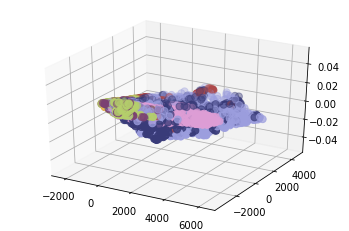

In [13]:
r = np.exp(-(X ** 2).sum(1))
two_pca = PCA(n_components=3)
model = two_pca.fit_transform(X)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=model[:, 0], ys=model[:, 1], zs=r, c=y, s=50, cmap='tab20b')
plt.show()

### **SVM**

In [15]:
np.random.seed(0)


X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=123)
svm_parameters = [{'kernel': ['rbf'], 'gamma': [0.0001, 0.001],'C': [1, 5, 10, 50]}] 

#svm_parameters = [{'kernel': ['rbf'], 'C': [1,10,100]}]                
clf = GridSearchCV(SVC(), svm_parameters, cv=3, verbose=2)
clf.fit(X_train, y_train)    
clf.best_params_
means=clf.cv_results_['mean_test_score']
stds=clf.cv_results_['std_test_score']

print(clf.best_params_)
print(means)
print(stds)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] C=1, gamma=0.0001, kernel=rbf ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................... C=1, gamma=0.0001, kernel=rbf, total=  19.7s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.7s remaining:    0.0s


[CV] .................... C=1, gamma=0.0001, kernel=rbf, total=  19.5s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................
[CV] .................... C=1, gamma=0.0001, kernel=rbf, total=  19.4s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=  17.3s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=  17.4s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=  17.4s
[CV] C=5, gamma=0.0001, kernel=rbf ...................................
[CV] .................... C=5, gamma=0.0001, kernel=rbf, total=  19.6s
[CV] C=5, gamma=0.0001, kernel=rbf ...................................
[CV] .................... C=5, gamma=0.0001, kernel=rbf, total=  20.0s
[CV] C=5, gamma=0.0001, kernel=rbf ...................................
[CV] .

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  7.3min finished


{'C': 5, 'gamma': 0.0001, 'kernel': 'rbf'}
[0.76512897 0.37169312 0.7786045  0.40236442 0.77794312 0.40236442
 0.77777778 0.40236442]
[0.00815315 0.00225802 0.00943837 0.00234707 0.00996669 0.00234707
 0.00983553 0.00234707]


In [20]:
np.random.seed(0)


X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=123)
svm_parameters = [{'kernel': ['rbf'], 'gamma': [0.00001],'C': [5, 10, 50]}] 

#svm_parameters = [{'kernel': ['rbf'], 'C': [1,10,100]}]                
clf = GridSearchCV(SVC(), svm_parameters, cv=3, verbose=2)
clf.fit(X_train, y_train)    
clf.best_params_
means=clf.cv_results_['mean_test_score']
stds=clf.cv_results_['std_test_score']

print(clf.best_params_)
print(means)
print(stds)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] C=5, gamma=1e-05, kernel=rbf ....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..................... C=5, gamma=1e-05, kernel=rbf, total=   8.2s
[CV] C=5, gamma=1e-05, kernel=rbf ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.2s remaining:    0.0s


[CV] ..................... C=5, gamma=1e-05, kernel=rbf, total=   8.1s
[CV] C=5, gamma=1e-05, kernel=rbf ....................................
[CV] ..................... C=5, gamma=1e-05, kernel=rbf, total=   8.2s
[CV] C=10, gamma=1e-05, kernel=rbf ...................................
[CV] .................... C=10, gamma=1e-05, kernel=rbf, total=   8.1s
[CV] C=10, gamma=1e-05, kernel=rbf ...................................
[CV] .................... C=10, gamma=1e-05, kernel=rbf, total=   7.9s
[CV] C=10, gamma=1e-05, kernel=rbf ...................................
[CV] .................... C=10, gamma=1e-05, kernel=rbf, total=   8.0s
[CV] C=50, gamma=1e-05, kernel=rbf ...................................
[CV] .................... C=50, gamma=1e-05, kernel=rbf, total=   8.0s
[CV] C=50, gamma=1e-05, kernel=rbf ...................................
[CV] .................... C=50, gamma=1e-05, kernel=rbf, total=   7.9s
[CV] C=50, gamma=1e-05, kernel=rbf ...................................
[CV] .

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.2min finished


{'C': 10, 'gamma': 1e-05, 'kernel': 'rbf'}
[0.83515212 0.83763228 0.83614418]
[0.00870846 0.00942098 0.0054801 ]


In [21]:
model=clf.best_estimator_
yfit=model.predict(X_test)

In [31]:
y_labels=train_df['Cover_Type']
y_labels.replace({1:'Spruce/Fir', 2: 'Lodgepole Pine', 3: 'Ponderosa Pine', 4: 'Cottonwood/Willow', 5: 'Aspen', 6: 'Douglas Fir', 7: ' Krummholz'}, inplace=True)

In [40]:

from sklearn.metrics import classification_report
print(classification_report(y_test, yfit, target_names=np.unique(y_labels)))

                   precision    recall  f1-score   support

        Krummholz       0.80      0.73      0.76       453
            Aspen       0.69      0.68      0.69       382
Cottonwood/Willow       0.87      0.83      0.85       429
      Douglas Fir       0.94      0.97      0.96       428
   Lodgepole Pine       0.92      0.95      0.94       463
   Ponderosa Pine       0.84      0.89      0.87       450
       Spruce/Fir       0.94      0.96      0.95       419

         accuracy                           0.86      3024
        macro avg       0.86      0.86      0.86      3024
     weighted avg       0.86      0.86      0.86      3024



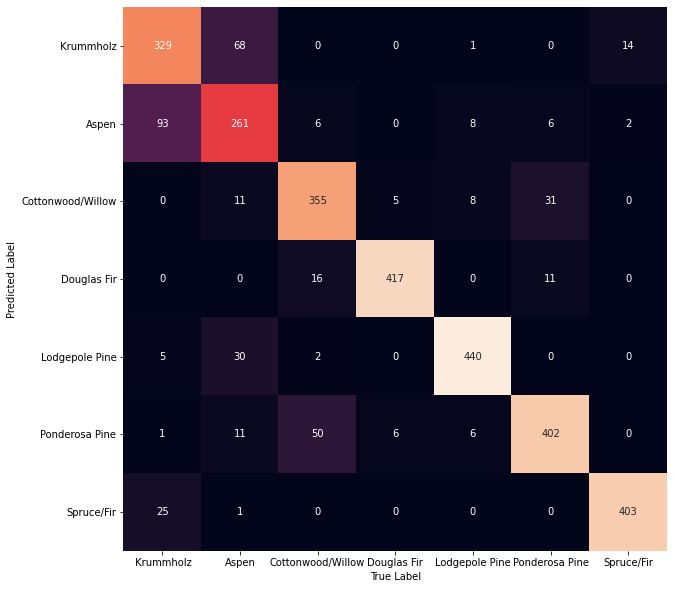

In [41]:
mat = confusion_matrix(y_test, yfit)
plt.figure(figsize=(10,10))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(y_labels),
            yticklabels=np.unique(y_labels))
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.show()